# Compute persistence and climatology scores for benchmark

In [41]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [3]:
DATADIR = '/data/weather-benchmark/5.625deg/geopotential_500/'

In [4]:
!ls $DATADIR

geopotential_500_1979_5.625deg.nc  geopotential_500_1999_5.625deg.nc
geopotential_500_1980_5.625deg.nc  geopotential_500_2000_5.625deg.nc
geopotential_500_1981_5.625deg.nc  geopotential_500_2001_5.625deg.nc
geopotential_500_1982_5.625deg.nc  geopotential_500_2002_5.625deg.nc
geopotential_500_1983_5.625deg.nc  geopotential_500_2003_5.625deg.nc
geopotential_500_1984_5.625deg.nc  geopotential_500_2004_5.625deg.nc
geopotential_500_1985_5.625deg.nc  geopotential_500_2005_5.625deg.nc
geopotential_500_1986_5.625deg.nc  geopotential_500_2006_5.625deg.nc
geopotential_500_1987_5.625deg.nc  geopotential_500_2007_5.625deg.nc
geopotential_500_1988_5.625deg.nc  geopotential_500_2008_5.625deg.nc
geopotential_500_1989_5.625deg.nc  geopotential_500_2009_5.625deg.nc
geopotential_500_1990_5.625deg.nc  geopotential_500_2010_5.625deg.nc
geopotential_500_1991_5.625deg.nc  geopotential_500_2011_5.625deg.nc
geopotential_500_1992_5.625deg.nc  geopotential_500_2012_5.625deg.nc
geopotential_500_1993_5.625deg.nc 

In [5]:
z500 = xr.open_mfdataset(f'{DATADIR}*')

In [6]:
z500

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 64, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<shape=(350640, 33, 64), chunksize=(8760, 33, 64)>
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-18 08:52:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

## Persistence

In [27]:
z500_validation = z500.sel(time=slice('2017', '2018'))

In [129]:
z500_validation

<xarray.Dataset>
Dimensions:    (lat: 33, lon: 64, time: 17520)
Coordinates:
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat        (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 78.75 84.38 90.0
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z          (time, lat, lon) float32 dask.array<shape=(17520, 33, 64), chunksize=(8760, 33, 64)>
    time.week  (time) int64 52 52 52 52 52 52 52 52 52 52 ... 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-18 08:52:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [58]:
def compute_persistence_rmse(da, lead_time_h, var='z'):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    da_fc = da.isel(time=slice(0, -lead_time_h))
    da_true = da.isel(time=slice(lead_time_h, None))
    da_fc['time'] = da_true.time
    return np.sqrt(((da_fc - da_true)**2).mean())

In [40]:
scores = []
lead_times = np.arange(1, 121, 1)
for lead_time_h in lead_times:
    rmse = compute_persistence_rmse(z500_validation.z, lead_time_h).values
    scores.append(rmse)

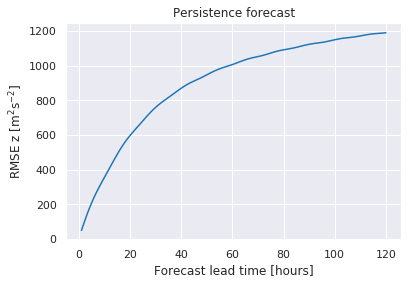

In [55]:
plt.plot(lead_times, scores)
plt.ylabel(r'RMSE z [m$^2$s$^{-2}$]')
plt.xlabel('Forecast lead time [hours]')
plt.title('Persistence forecast');

In [59]:
compute_persistence_rmse(z500_validation.z, 3*24).values

array(1060.091, dtype=float32)

In [60]:
compute_persistence_rmse(z500_validation.z, 5*24).values

array(1190.4475, dtype=float32)

## Climatology

In [98]:
def compute_climatology_rmse(da_train, da_true):
    mean = da_train.mean('time')
    return np.sqrt(((mean - da_true)**2).mean())

In [122]:
z500_train = z500.sel(time=slice(None, '2016'))

In [128]:
z500_train

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 64, time: 333120)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 1979-01-01 ... 2016-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<shape=(333120, 33, 64), chunksize=(8760, 33, 64)>
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-18 08:52:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

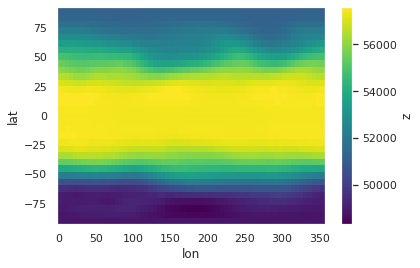

In [124]:
z500_train.mean('time').z.plot();

In [125]:
compute_climatology_rmse(z500_train.z, z500_validation.z).values

array(1268.6232, dtype=float32)

In [126]:
def compute_weekly_climatology_rmse(da_train, da_true):
    da_train['week'] = da_train['time.week']
    da_true['week'] = da_true['time.week']
    weekly_averages = da_train.groupby('week').mean('time')
    # There is probably a better way of doing this but hey it works
    errors = []
    for w in range(1, 53):
        errors.append(
            da_true[da_true['week'] == w] - weekly_averages.sel(week = w)
        )
    errors = xr.concat(errors, dim='time')
    return np.sqrt((errors**2).mean())

In [127]:
compute_weekly_climatology_rmse(z500_train.z, z500_validation.z).values

array(958.1201, dtype=float32)

The End